In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.abc import x, a, b, t, s

Discretized / Linearized(?) Laplace-operator:

$H := \text{discretize}(\Delta)$

$\text{d}x^{(0)} = -Hx^{(1)}(t)\text{d}t$

$\text{d}x^{(1)}(t) = \sigma \text{d}w(t) $

$\overset{\to}{x} = [x^{(0)} \;\; x^{(1)}]^\top$

$\text{d}\overset{\to}{x} = \begin{bmatrix} 0 & -H \\ 0 & 0 \end{bmatrix} \text{d}w(t) + \begin{bmatrix} 0 \\ \sigma \end{bmatrix} w(t) $

In [2]:
times = np.linspace(0, 20, 20)
H = 1.0
sigma = 0.05

trans = np.array(
    [
        [0, 1, 0],
        [-H, -0.4, 1],
        [0, 0.0, 0],
    ]
)
noise_filter = np.array([0, 0, 1]) * sigma

# initial condition
y0 = [1.0, 0, 0]

In [3]:
display(trans), display(noise_filter);

array([[ 0. ,  1. ,  0. ],
       [-1. , -0.4,  1. ],
       [ 0. ,  0. ,  0. ]])

array([0.  , 0.  , 0.05])

$$u'' = -u -u' + f$$
$$\text{d}f = \sigma \text{d}w(t)$$

$$\updownarrow$$

$$\text{d}\begin{bmatrix}u \\ u' \\ f \end{bmatrix} = \begin{bmatrix}0 & 1 & 0 \\ -1 & -1 & 1 \\ 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} u \\ u' \\ f \end{bmatrix}\text{d}t + \begin{bmatrix} 0 \\ 0 \\ \sigma \end{bmatrix} \text{d}w(t)$$

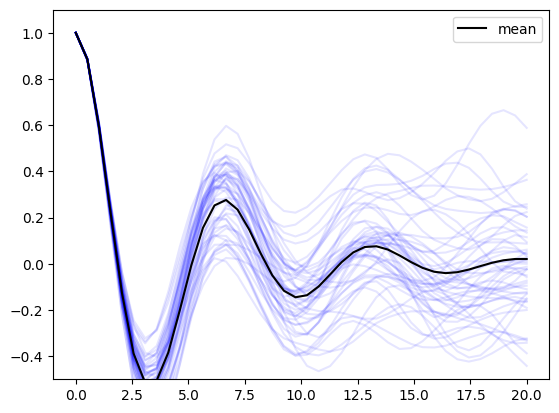

In [4]:
import functools as ft

from scipy.linalg import expm
from scipy.integrate import quad_vec


def step(prev, A, Q):
    return A @ prev + np.random.multivariate_normal(np.zeros(A.shape[0]), Q)


def integrand(t):
    return expm(trans * t) @ (np.outer(noise_filter, noise_filter)) @ expm(trans.T * t)


def get_discrete_system_coeffs(trans, noise_filter, time_step):
    A = expm(trans * time_step)
    Q, _ = quad_vec(integrand, 0, time_step)
    return A, Q


A, Q = get_discrete_system_coeffs(trans, noise_filter, 0.5)

steps = int(times.max() / 0.5)

for _ in range(50):
    xs = ft.reduce(
        lambda agg, _: np.vstack([agg, step(agg[-1], A, Q)]),
        range(steps - 1),
        np.array(y0).reshape(1, -1),
    )
    plt.plot(np.linspace(0, times.max(), steps), xs[:, 0], alpha=0.1, color="blue")
mean = ft.reduce(
    lambda agg, _: np.vstack([agg, step(agg[-1], A, Q * 0)]),
    range(steps - 1),
    np.array(y0).reshape(1, -1),
)
plt.plot(np.linspace(0, times.max(), steps), mean[:, 0], label="mean", color="black")
plt.legend()
plt.ylim(-0.5, 1.1);

3


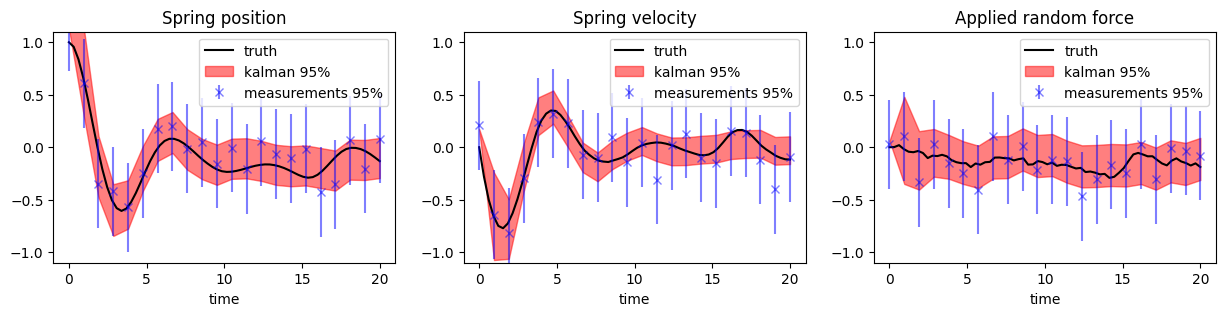

In [5]:
system_freq = 0.3
measure_freq = 1.0
Ah, Qh = get_discrete_system_coeffs(trans, noise_filter, system_freq)  # high frequency
stepsh = int(times.max() / system_freq)

Al, Ql = get_discrete_system_coeffs(trans, noise_filter, measure_freq)  # low frequency
stepsl = int(times.max() / measure_freq)

from filterpy.kalman import KalmanFilter

initial_obs = np.array(y0)

filter = KalmanFilter(dim_x=3, dim_z=3)
filter.x = initial_obs
filter.F = Al
filter.Q = Ql
filter.H = np.eye(3)
filter.R = np.eye(3) * 0.02

current = initial_obs

true_trajectory = []

measured_trajectory = []
forward_mean_ests = []
forward_cov_est = []
obs = current

print(int(np.round((measure_freq) / system_freq)))


for i in range(stepsh):
    true_trajectory.append(current)

    if i % int(np.round((measure_freq) / system_freq)) == 0:
        obs = filter.H @ current + np.random.multivariate_normal(
            np.zeros(len(filter.R)), filter.R
        )
        measured_trajectory.append(obs.copy())
        forward_cov_est.append(np.diag(filter.P))
        filter.predict()
        filter.update(obs)
        forward_mean_ests.append(filter.x)

    current = step(current, Ah, Qh)


true_trajectory = np.array(true_trajectory)
forward_mean_ests = np.array(forward_mean_ests)
forward_cov_est = np.array(forward_cov_est)
forward_cov_est[0] *= 0
measured_trajectory = np.array(measured_trajectory)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

x_axish = np.linspace(0, times.max(), len(true_trajectory))
x_axisl = np.linspace(0, times.max(), len(measured_trajectory))


row_0_titles = ["Spring position", "Spring velocity", "Applied random force"]
for i in range(3):
    ax[i].plot(x_axish, true_trajectory[:, i], label="truth", color="black")
    ax[i].errorbar(
        x_axisl,
        measured_trajectory[:, i],
        yerr=np.sqrt(filter.R[0, 0]) * 3,
        label="measurements 95%",
        color="blue",
        fmt="x",
        alpha=0.5,
    )
    ax[i].fill_between(
        x_axisl,
        forward_mean_ests[:, i] - 3 * np.sqrt(forward_cov_est[:, i]),
        forward_mean_ests[:, i] + 3 * np.sqrt(forward_cov_est[:, i]),
        alpha=0.5,
        color="red",
        label="kalman 95%",
    )
    ax[i].set_ylim(-1.1, 1.1)
    ax[i].legend()
    ax[i].set_title(row_0_titles[i])
    ax[i].set_xlabel("time")

### Doing the same as above, but changing the observation function - we now only see the position and have to estimate velocity and the random force being applied

3


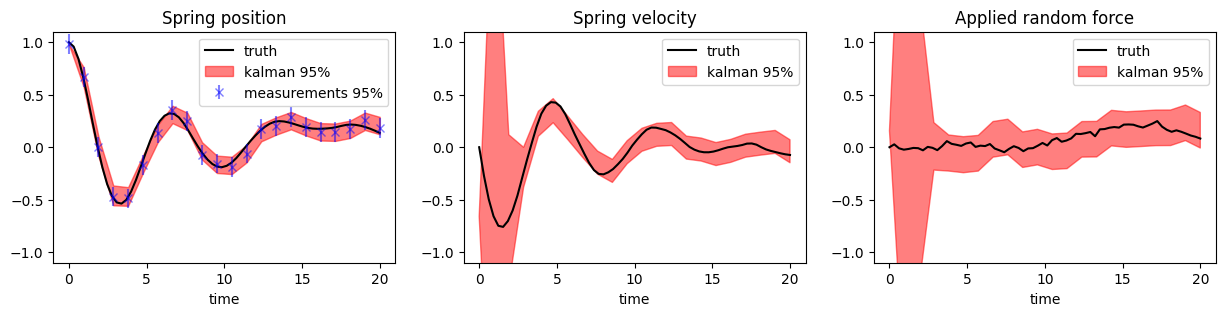

In [6]:
initial_obs = np.array(y0)

filter = KalmanFilter(dim_x=3, dim_z=1)
filter.x = initial_obs
filter.F = Al
filter.Q = Ql
filter.H = np.array([[1, 0, 0]])
filter.R = np.array([[0.001]])

current = initial_obs

true_trajectory = []

measured_trajectory = []
forward_mean_ests = []
forward_cov_est = []
obs = current

print(int(np.round((measure_freq) / system_freq)))


for i in range(stepsh):
    true_trajectory.append(current)

    if i % int(np.round((measure_freq) / system_freq)) == 0:
        obs = filter.H @ current + np.random.multivariate_normal(
            np.zeros(len(filter.R)), filter.R
        )
        measured_trajectory.append(obs.copy())
        forward_cov_est.append(np.diag(filter.P))
        filter.predict()
        filter.update(obs)
        forward_mean_ests.append(filter.x)

    current = step(current, Ah, Qh)


true_trajectory = np.array(true_trajectory)
forward_mean_ests = np.array(forward_mean_ests)
forward_cov_est = np.array(forward_cov_est)
forward_cov_est[0] *= 0
measured_trajectory = np.array(measured_trajectory)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

x_axish = np.linspace(0, times.max(), len(true_trajectory))
x_axisl = np.linspace(0, times.max(), len(measured_trajectory))


row_0_titles = ["Spring position", "Spring velocity", "Applied random force"]
for i in range(3):
    ax[i].plot(x_axish, true_trajectory[:, i], label="truth", color="black")
    if i == 0:
        ax[i].errorbar(
            x_axisl,
            measured_trajectory[:, i],
            yerr=np.sqrt(filter.R[0, 0]) * 3,
            label="measurements 95%",
            color="blue",
            fmt="x",
            alpha=0.5,
        )
    ax[i].fill_between(
        x_axisl,
        forward_mean_ests[:, i] - 3 * np.sqrt(forward_cov_est[:, i]),
        forward_mean_ests[:, i] + 3 * np.sqrt(forward_cov_est[:, i]),
        alpha=0.5,
        color="red",
        label="kalman 95%",
    )
    ax[i].set_ylim(-1.1, 1.1)
    ax[i].legend()
    ax[i].set_title(row_0_titles[i])
    ax[i].set_xlabel("time")

### Looking at Kalman smoother

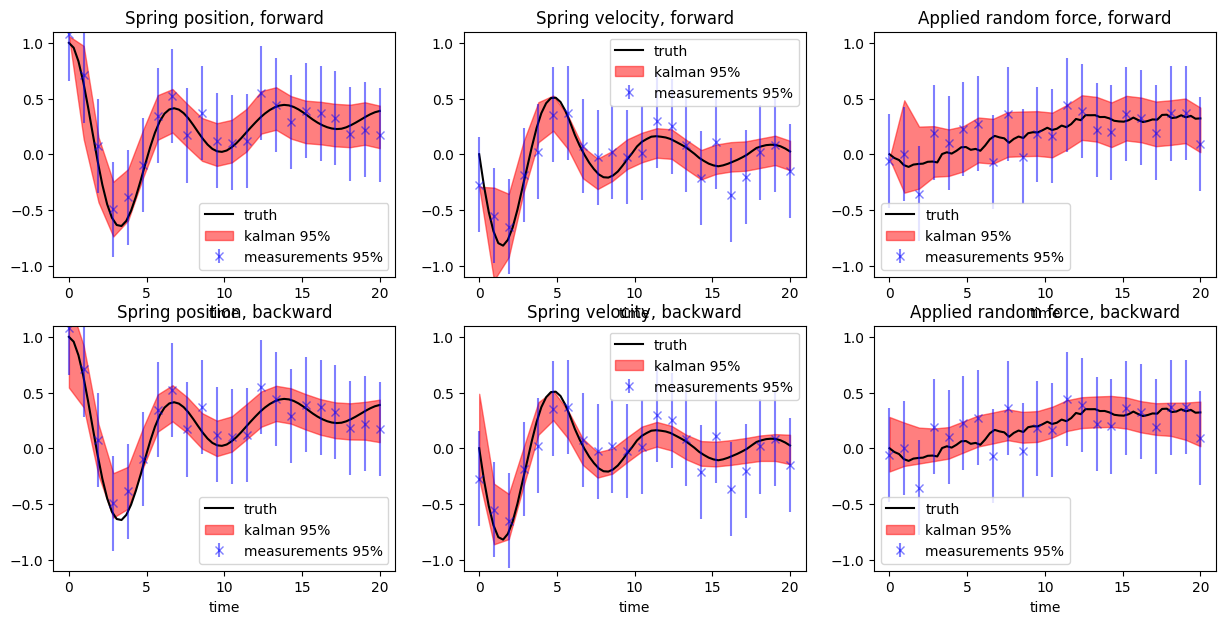

In [7]:
initial_obs = np.array(y0)

filter = KalmanFilter(dim_x=3, dim_z=3)
filter.x = initial_obs
filter.F = Al
filter.Q = Ql
filter.H = np.eye(3)
filter.R = np.eye(3) * 0.02

current = initial_obs

true_trajectory = []

measured_trajectory = []
forward_mean_ests = []
forward_cov_est = []
obs = current

for i in range(stepsh):
    true_trajectory.append(current)

    if i % int(np.round((measure_freq) / system_freq)) == 0:
        obs = filter.H @ current + np.random.multivariate_normal(
            np.zeros(len(filter.R)), filter.R
        )
        measured_trajectory.append(obs.copy())
        forward_cov_est.append(filter.P)
        filter.predict()
        filter.update(obs)
        forward_mean_ests.append(filter.x)

    current = step(current, Ah, Qh)

# batch convert to numpy arrays
measured_trajectory = np.array(measured_trajectory)
true_trajectory = np.array(true_trajectory)
forward_mean_ests = np.array(forward_mean_ests)
forward_cov_est = np.array(forward_cov_est)


(smooth_mean_ests, smooth_cov_matrix_est, _, _) = filter.rts_smoother(
    forward_mean_ests, forward_cov_est
)
smooth_var_est = np.diagonal(smooth_cov_matrix_est, axis1=1, axis2=2)
forward_var_est = np.diagonal(forward_cov_est, axis1=1, axis2=2)

# manually set the first uncertainty to 0 🤷‍♂️
forward_cov_est[0] *= 0

fig, ax = plt.subplots(2, 3, figsize=(15, 7))

x_axish = np.linspace(0, times.max(), len(true_trajectory))
x_axisl = np.linspace(0, times.max(), len(measured_trajectory))


row_0_titles = [
    "Spring position, forward",
    "Spring velocity, forward",
    "Applied random force, forward",
]
row_1_titles = [
    "Spring position, backward",
    "Spring velocity, backward",
    "Applied random force, backward",
]

for i in range(3):
    ax[0, i].plot(x_axish, true_trajectory[:, i], label="truth", color="black")
    ax[0, i].errorbar(
        x_axisl,
        measured_trajectory[:, i],
        yerr=np.sqrt(filter.R[0, 0]) * 3,
        label="measurements 95%",
        color="blue",
        fmt="x",
        alpha=0.5,
    )
    ax[0, i].fill_between(
        x_axisl,
        forward_mean_ests[:, i] - 3 * np.sqrt(forward_var_est[:, i]),
        forward_mean_ests[:, i] + 3 * np.sqrt(forward_var_est[:, i]),
        alpha=0.5,
        color="red",
        label="kalman 95%",
    )
    ax[0, i].set_ylim(-1.1, 1.1)
    ax[0, i].legend()
    ax[0, i].set_title(row_0_titles[i])
    ax[0, i].set_xlabel("time")

for i in range(3):
    ax[1, i].plot(x_axish, true_trajectory[:, i], label="truth", color="black")
    ax[1, i].errorbar(
        x_axisl,
        measured_trajectory[:, i],
        yerr=np.sqrt(filter.R[0, 0]) * 3,
        label="measurements 95%",
        color="blue",
        fmt="x",
        alpha=0.5,
    )
    ax[1, i].fill_between(
        x_axisl,
        smooth_mean_ests[:, i] - 3 * np.sqrt(smooth_var_est[:, i]),
        smooth_mean_ests[:, i] + 3 * np.sqrt(smooth_var_est[:, i]),
        alpha=0.5,
        color="red",
        label="kalman 95%",
    )
    ax[1, i].set_ylim(-1.1, 1.1)
    ax[1, i].legend()
    ax[1, i].set_title(row_1_titles[i])
    ax[1, i].set_xlabel("time")

### Probabilistic Solver

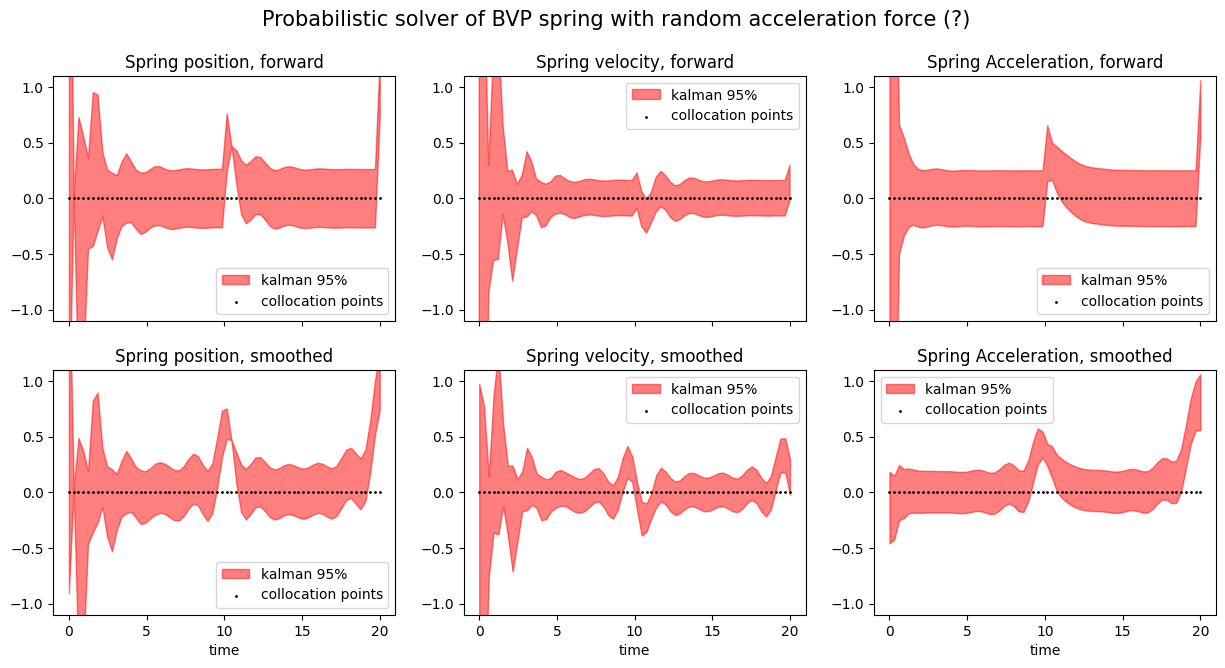

In [8]:
times = np.linspace(0, 20, 20)
sigma = 1.05

trans = np.array(
    [
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],
    ]
)
noise_filter = np.array([0, 0, 1]) * sigma

# initial condition
y0 = [1.0, 0, 0]

system_freq = 0.3
measure_freq = 1.0
Ah, Qh = get_discrete_system_coeffs(trans, noise_filter, system_freq)  # high frequency
stepsh = int(times.max() / system_freq)

from filterpy.kalman import KalmanFilter

initial_obs = np.array(y0)

filter = KalmanFilter(dim_x=3, dim_z=1)
filter.x = initial_obs
filter.F = Al
filter.Q = Ql

filter.H = np.array([[-0.3, -0.00, -1]])
filter.R = np.ones((1, 1)) * 0.00001

current = initial_obs

measured_trajectory = []
forward_mean_ests = []
forward_cov_est = []
obs = current

for i in range(stepsh):
    obs = np.zeros((1, 1))
    measured_trajectory.append(obs.copy())
    forward_cov_est.append(filter.P)

    filter.R = np.array([[0.0000001]])
    if i == 0:
        prevH = filter.H.copy()
        filter.H = np.array([[1, 0, 0]])

        filter.predict()
        filter.update(initial_obs[0])
        filter.H = prevH

    elif i == stepsh - 1:
        prevH = filter.H.copy()
        filter.H = np.array([[1, 0, 0]])

        filter.predict()
        filter.update(initial_obs[0])
        filter.H = prevH

    elif i == stepsh // 2:
        prevH = filter.H.copy()
        filter.H = np.array([[1, 0, 0]])

        filter.predict()
        filter.update(initial_obs[0] * 0.5)
        filter.H = prevH

    else:
        filter.R = np.array([[0.041]])
        filter.predict()
        filter.update([0])

    forward_mean_ests.append(filter.x)
    current = step(current, Ah, Qh)


# batch convert to numpy arrays
measured_trajectory = np.array(measured_trajectory)
true_trajectory = np.array(true_trajectory)
forward_mean_ests = np.array(forward_mean_ests)
forward_cov_est = np.array(forward_cov_est)

(smooth_mean_ests, smooth_cov_matrix_est, _, _) = filter.rts_smoother(
    forward_mean_ests, forward_cov_est
)
smooth_var_est = np.diagonal(smooth_cov_matrix_est, axis1=1, axis2=2)
forward_var_est = np.diagonal(forward_cov_est, axis1=1, axis2=2)

# make subplots with proper spacing
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True)

x_axish = np.linspace(0, times.max(), len(true_trajectory))

row_0_titles = [
    "Spring position, forward",
    "Spring velocity, forward",
    "Spring Acceleration, forward",
]
row_1_titles = [
    "Spring position, smoothed",
    "Spring velocity, smoothed",
    "Spring Acceleration, smoothed",
]

# title for the whole figure, big font
fig.text(
    0.5,
    1 - 0.04,
    "Probabilistic solver of BVP spring with random acceleration force (?)",
    ha="center",
    va="center",
    fontsize=15,
)

for i in range(3):
    ax[0, i].fill_between(
        x_axish,
        forward_mean_ests[:, i] - 3 * np.sqrt(forward_var_est[:, i]),
        forward_mean_ests[:, i] + 3 * np.sqrt(forward_var_est[:, i]),
        alpha=0.5,
        color="red",
        label="kalman 95%",
    )
    ax[0, i].scatter(
        x_axish, [0.0] * len(x_axish), label="collocation points", color="black", s=1
    )
    ax[0, i].set_ylim(-1.1, 1.1)
    ax[0, i].legend()
    ax[0, i].set_title(row_0_titles[i])

for i in range(3):
    ax[1, i].fill_between(
        x_axish,
        smooth_mean_ests[:, i] - 3 * np.sqrt(smooth_var_est[:, i]),
        smooth_mean_ests[:, i] + 3 * np.sqrt(smooth_var_est[:, i]),
        alpha=0.5,
        color="red",
        label="kalman 95%",
    )
    ax[1, i].scatter(
        x_axish, [0.0] * len(x_axish), label="collocation points", color="black", s=1
    )
    ax[1, i].set_ylim(-1.1, 1.1)
    ax[1, i].legend()
    ax[1, i].set_title(row_1_titles[i])
    ax[1, i].set_xlabel("time")